## Imports & Setup

In [31]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.EnsembleFour import *

from torchsampler import ImbalancedDatasetSampler

In [32]:
torch.manual_seed(809)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


RandomAffine(degrees=(-30,30),translate=(0.1,0.1),shear=(-10,10)),
                          RandomResizedCrop((size,size),scale=(0.8,1),ratio=(0.9,1.1)),

## Prepare Dataset

In [34]:
def create_subsets(root, transformation):
    dataset = ImageFolder(root, transformation)
    train, test, val = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
    return train, test, val

In [35]:
def produce_loaders(train, test, val):
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    valid_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = False)
    return train_loader, test_loader, valid_loader

In [36]:
size = 44
batch_size = 256
transformation = Compose([RandomHorizontalFlip(), 
                          Resize((size, size)), ToTensor()])

In [37]:
root = '../reduced_dataset/cropped_augmented/'
train_data, test_data, val_data = create_subsets(root, transformation)
train_loader, test_loader, val_loader = produce_loaders(train_data, test_data, val_data)

[96, 1861, 2563, 2083, 2054, 1896, 2107, 1091, 2570]


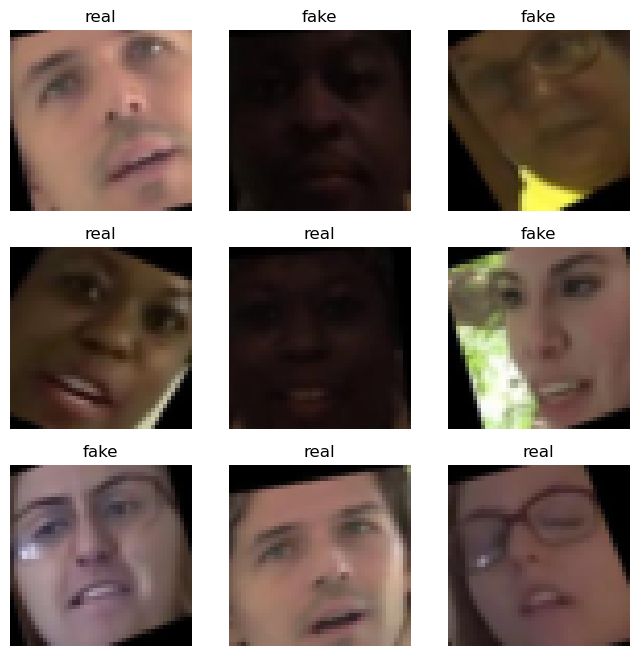

In [39]:
visualize_data(train_data)

[142, 84, 35, 456, 23, 43, 333, 480, 89]


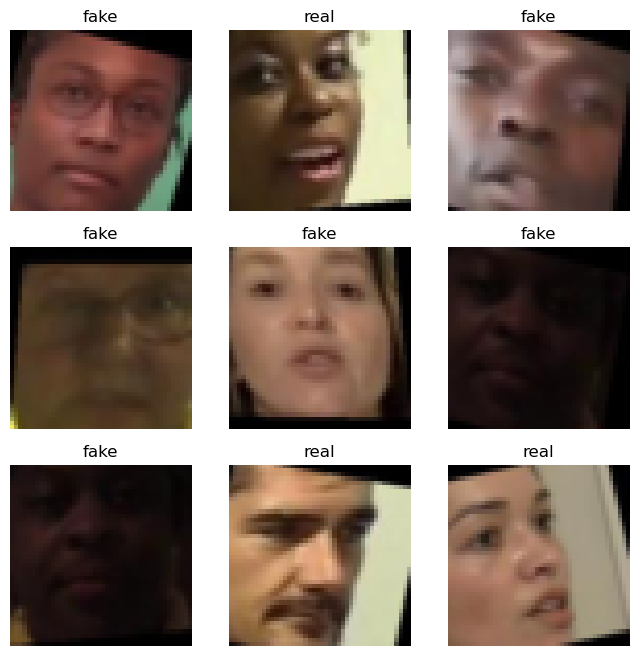

In [40]:
visualize_data(test_data)

## Initialize Model

In [41]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [42]:
from math import floor
# number of hidden layers and their sizes
hidden = [3, 256, 128, 64]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]

In [43]:
model = DeepSearch(hidden=hidden, kernel_size=kernel_size,
                   window=window, hidden_linear=hidden_linear).to(device)
#model.load_state_dict(torch.load("./DeepSearch2_15epochs")["model_state_dict"])
print(model)

DeepSearch(
  (conv_combined): Sequential(
    (0): DeepSearchConv(
      (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): DeepSearchConv(
      (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): DeepSearchConv(
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (linear_combined): Sequential(
    (0): DeepSearchLinear(
      (linear): Linear(in_features=23104, out_features=512, bias=True)
      (batch_norm): BatchN

## Training Model

In [45]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [46]:
optimizer = create_adam_optimizer(model, lr=0.001)
#optimizer.load_state_dict(torch.load("./DeepSearch2_15epochs")["optimizer_state_dict"])

In [47]:
# repeat this cell with epochs = 1 for safety, but usually epochs = 3 is a good start

"""
train function params:
device
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)

returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves

"""
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 20)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.53515625
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.6009114583333334
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.6420454545454546
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.671078431372549
--- Epoch 1/20: Train loss: 0.6278, Train accuracy: 0.6711
--- Epoch 1/20: Val loss: 0.6713, Val accuracy: 0.5647
Epoch 2/20, Batch number: 0, Cumulated accuracy: 0.71484375
Epoch 2/20, Batch number: 5, Cumulated accuracy: 0.7291666666666666
Epoch 2/20, Batch number: 10, Cumulated accuracy: 0.7325994318181818
Epoch 2/20, Batch number: 15, Cumulated accuracy: 0.7404411764705883
--- Epoch 2/20: Train loss: 0.5451, Train accuracy: 0.7404
--- Epoch 2/20: Val loss: 0.7068, Val accuracy: 0.5431
Epoch 3/20, Batch number: 0, Cumulated accuracy: 0.78125
Epoch 3/20, Batch number: 5, Cumulated accuracy: 0.7662760416666666
Epoch 3/20, Batch number: 10, Cumulated accuracy: 0.7571022727272727
Epoch 3/20, Batch number: 15, Cumulated accurac

## Testing Model & Performance Curves

In [48]:
"""
test function params:
device
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  and values of the test loss and test accuracy (default is False)

by default, returns values of the test loss and test accuracy

"""
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)

Test loss: 0.4142, Test accuracy: 0.7941


Precision: 0.7424242424242424
Recall: 0.8412017167381974
F1 score: 0.7887323943661972


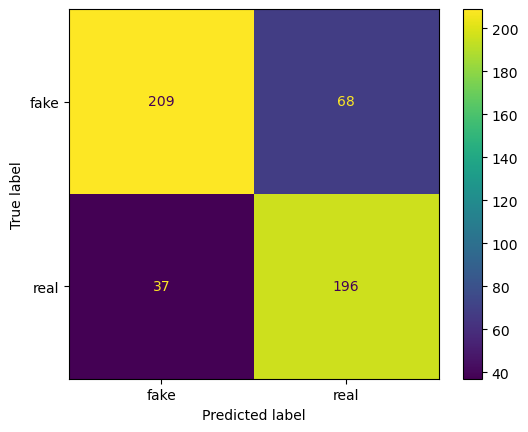

In [49]:
show_metrics(true_labels, model_preds)

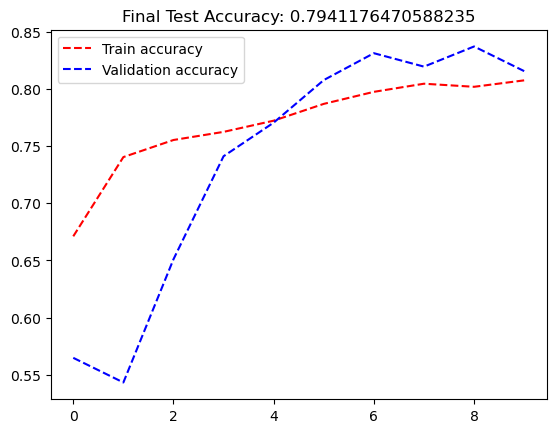

In [50]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

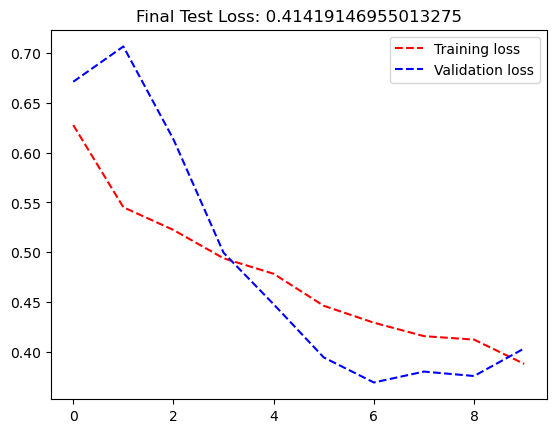

In [51]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [52]:
test_loader2 = produce_loader(test_data, 1)

In [53]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2)

Precision: 0.7413127413127413
Recall: 0.8240343347639485
F1 score: 0.7804878048780487


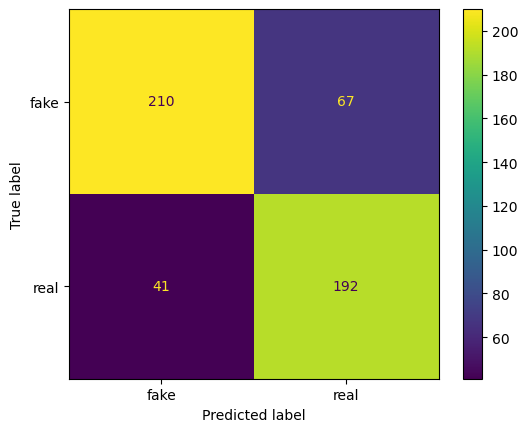

In [54]:
show_metrics(true_labels2, model_preds2)

[303, 362, 394, 357, 7, 75, 125, 190, 296, 265, 289, 189, 154, 280, 235, 65, 247, 257, 344, 189, 269, 133, 96, 200, 193]


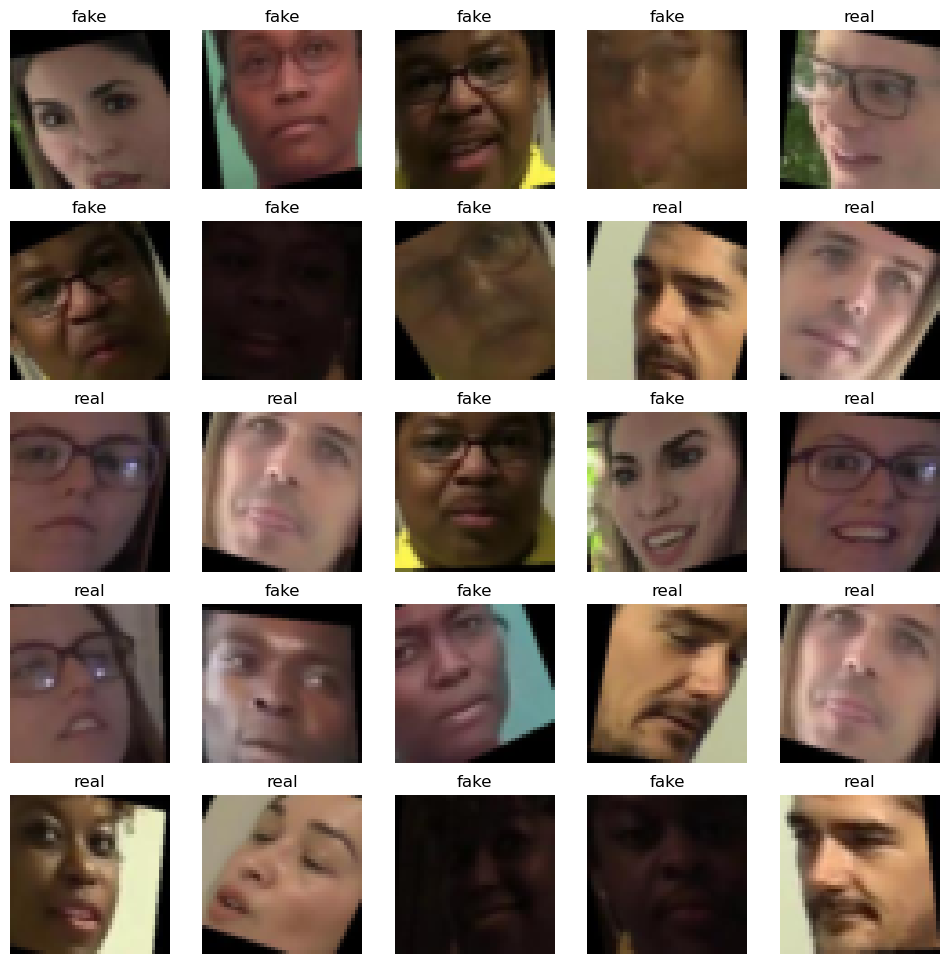

In [55]:
visualize_data(correct_list, (12,12), 5)

[32, 100, 100, 0, 89, 70, 48, 9, 84, 50, 24, 50, 14, 62, 27, 80, 48, 104, 43, 23, 81, 105, 52, 101, 96]


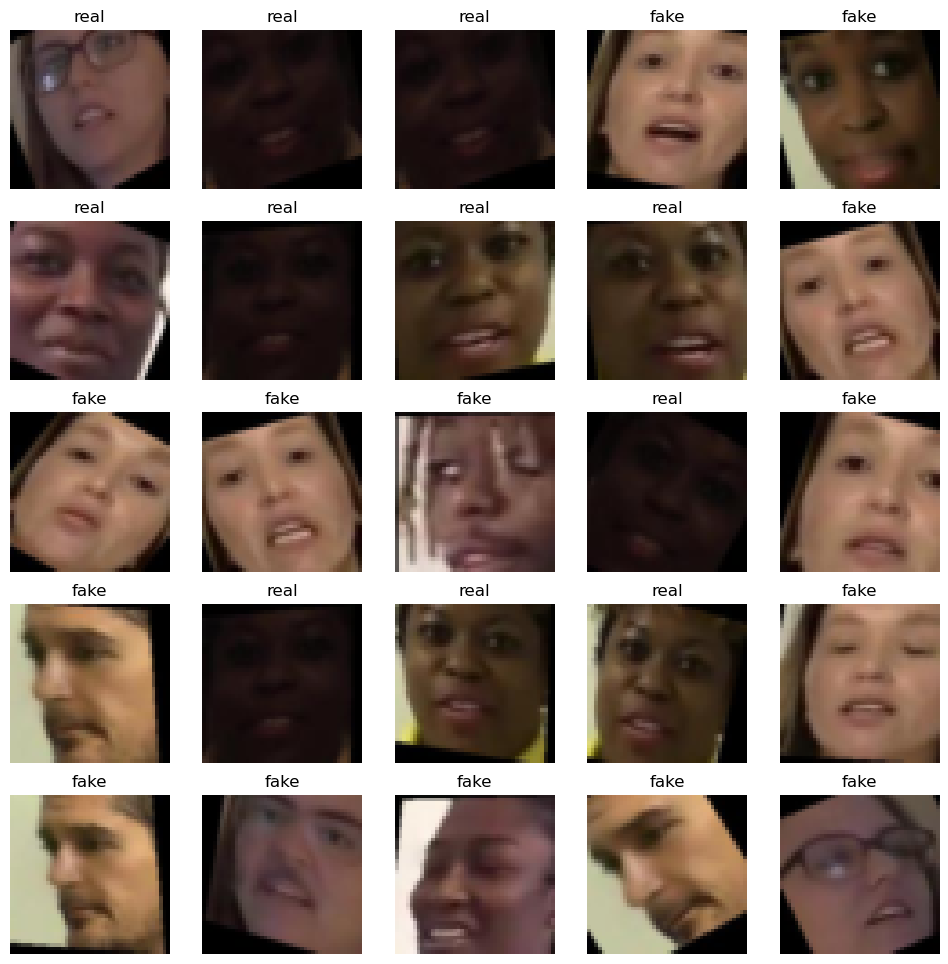

In [56]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

In [57]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './DeepSearch_19epochs')

model_test = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
model_test.load_state_dict(torch.load("./latest_16epochs")["model_state_dict"])